In [4]:
# Name: Kripa Gurung
# Student Id: 2332277

# Sentiment Analysis of Financial Phrase using RNN, LSTM, and Word2Vec Embeddings

## Imports

In [804]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string


In [805]:
# Download required resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Text Preprocessing, Tokenization, and Sequence Padding

### Text Pre Processing Pipeline



The `preprocess_text` function performs the following steps to clean the input text:

- Converts all characters to **lowercase**
- Removes **URLs**, **mentions (@username)**, and **hashtags (#hashtag)**
- Strips out **punctuation** and **numbers**
- Removes **stopwords** (common words like "the", "is", "and")
- Applies **lemmatization** to reduce words to their base form (e.g., "running" → "run")

These preprocessing steps help reduce noise and standardize the text, making it more suitable for training an RNN model.


In [806]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers

    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    processed_text = ' '.join(tokens)
    return processed_text

### Load the dataset

In [807]:
# Example: Load a CSV file with columns "text" and "label"
df = pd.read_csv("financial_phrase.csv")
df.head()


,text,label
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive


### Clean the text
Apply the cleaning on each row and store it in a clean_text column

In [808]:
df['cleaned_text'] = df['text'].apply(preprocess_text)
df

,text,label,cleaned_text
0,"According to Gran , the company has no plans t...",neutral,according gran company plan move production ru...
1,"For the last quarter of 2010 , Componenta 's n...",positive,last quarter componenta net sale doubled eurm ...
2,"In the third quarter of 2010 , net sales incre...",positive,third quarter net sale increased eur mn operat...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,operating profit rose eur mn eur mn correspond...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,operating profit totalled eur mn eur mn repres...
...,...,...,...
2259,Operating result for the 12-month period decre...,negative,operating result month period decreased profit...
2260,HELSINKI Thomson Financial - Shares in Cargote...,negative,helsinki thomson financial share cargotec fell...
2261,LONDON MarketWatch -- Share prices ended lower...,negative,london marketwatch share price ended lower lon...
2262,Operating profit fell to EUR 35.4 mn from EUR ...,negative,operating profit fell eur mn eur mn including ...


### Data Visualisation

In [809]:
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

#### Label Distribution

We check the distribution of sentiment labels in the dataset using `value_counts()`:


In [810]:
label_counts = df['label'].value_counts()
print(label_counts)

label
neutral     1391
positive     570
negative     303
Name: count, dtype: int64


- **Neutral**: 1391 samples  
- **Positive**: 570 samples  
- **Negative**: 303 samples  

This shows that the dataset is **imbalanced**, with a majority of samples labeled as *neutral*. This imbalance should be considered during model training and evaluation.

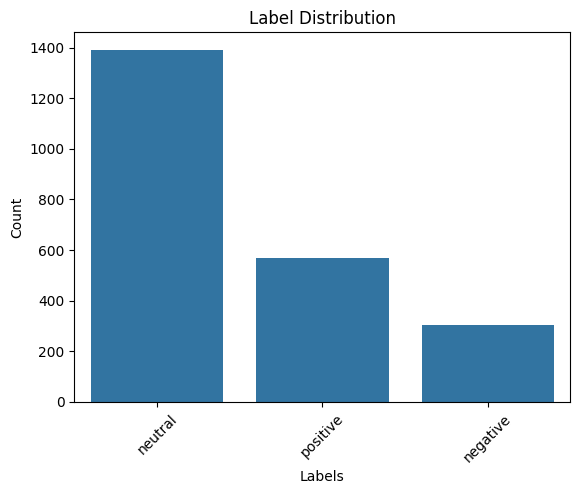

In [811]:
# Label Distribution
sns.countplot(x='label', data=df)
plt.title("Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

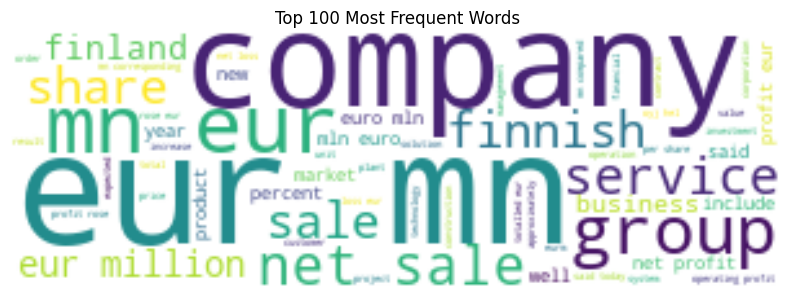

In [812]:
# --- Visualization: Word Cloud (Top 100 Words)
all_words = ''.join(df['cleaned_text'])

# Generate WordCloud with only top 100 words
wordcloud = WordCloud(
  width=300,
  height=100,
  background_color='white',
  max_words=100 # Limit to top 100 words

).generate(all_words)
# Plot settings
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 Most Frequent Words')
plt.show()

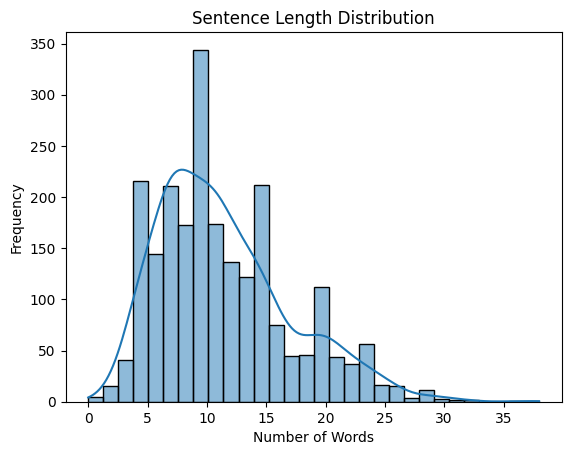

In [813]:
df['text_length'] = df['cleaned_text'].apply(lambda x: len(str(x).split()))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


The histogram shows the distribution of sentence lengths (in number of words) across the dataset.

- Most sentences contain **between 5 and 15 words**, with a peak around **10 words**.
- There are fewer very short or very long sentences.
- This distribution helps in choosing an appropriate **sequence length** for padding when preparing input for the RNN.

Based on this, we can set a maximum sequence length that captures most sentences without excessive padding or truncation.


### Splitting Data

In [814]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [815]:
X = df['cleaned_text']
y = df['label']  # expected values: 'yes', 'no', 'neutral'

# Split: 70% train, 15% validation, 15% test (stratified)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y 
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.15, random_state=42, stratify=y_train_full
)

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 1635
Validation size: 289
Test size: 340


### Train, Validation, and Test Split

The dataset is split into three parts using stratified sampling to maintain the label distribution across all sets:

- **Training set (70%)**: Used to train the model  
- **Validation set (15%)**: Used to tune model parameters and prevent overfitting  
- **Test set (15%)**: Used for final evaluation on unseen data

### Tokenization and Padding

In [816]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)  # Only fit on training data

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)  # Tokenize validation set
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Determine max_len using 95th percentile from training data
seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95))

# Pad sequences to max_len
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')  # Pad validation set
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


- A `Tokenizer` is initialized to keep the top 10,000 most frequent words. An out-of-vocabulary (OOV) token (`<OOV>`) is used for unseen words.
- The tokenizer is **fitted only on the training data** to avoid data leakage.
- Text data is converted into sequences of integers (each word → index).

To ensure uniform input length for the RNN:
- We calculate the **95th percentile** of sequence lengths in the training set.
- All sequences are **padded or truncated** to this `max_len` using **post-padding** and **post-truncating**.

This preserves most sentence lengths while avoiding excessive padding.


#### Label Encoding and One-Hot Conversion

In [817]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)  # Fit only on training labels

# Transform validation and test labels
y_val_enc = label_encoder.transform(y_val) 
y_test_enc = label_encoder.transform(y_test) 

# Convert to one-hot for categorical_crossentropy
y_train_cat = to_categorical(y_train_enc, num_classes=3)
y_val_cat = to_categorical(y_val_enc, num_classes=3)  # Encode validation labels
y_test_cat = to_categorical(y_test_enc, num_classes=3)

- Labels are first encoded using `LabelEncoder`, which converts categorical labels (`neutral`, `positive`, `negative`) into integer values (e.g., 0, 1, 2).
- The encoder is **fitted only on the training labels** to avoid data leakage.
- The same encoder is then used to transform the validation and test labels.

Since we are using `categorical_crossentropy` as the loss function, we convert the encoded labels into **one-hot vectors** using `to_categorical()`.

This format is required for multi-class classification with neural networks.


#### Visualize Sequence Length Distribution

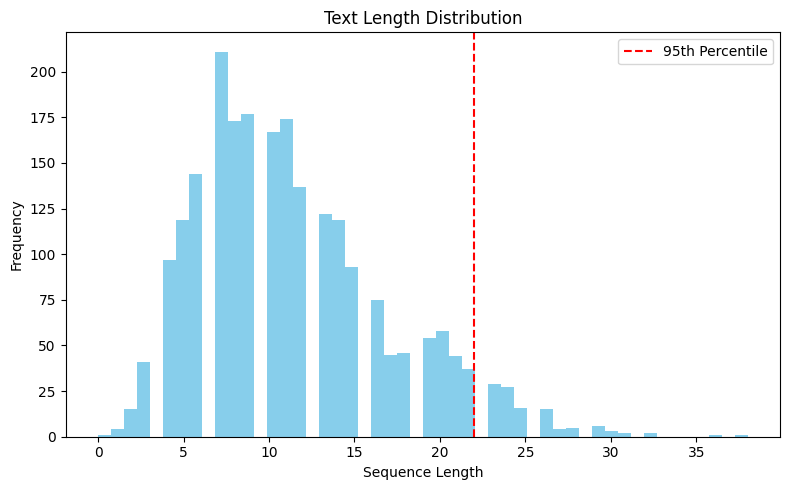

In [818]:
X_seq = tokenizer.texts_to_sequences(df['cleaned_text'])
all_seq_lengths = [len(seq) for seq in X_seq]

plt.figure(figsize=(8, 5))
plt.hist(all_seq_lengths, bins=50, color='skyblue')
plt.title('Text Length Distribution')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axvline(np.percentile(all_seq_lengths, 95), color='red', linestyle='dashed', label='95th Percentile')
plt.legend()
plt.tight_layout()
plt.show()

 - The 95th percentile indicates the value below which 95% of the sequence lengths fall. In this case, about 95% of the sequences are 22 tokens or fewer in length.
- This suggests that most of the text sequences in the dataset are relatively short, with only a small proportion of sequences exceeding 22 tokens.


## Model Building and Training

In [819]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [820]:
import gensim
gensim.__version__

'4.3.3'

#### Computing Class Weights

This step calculates **class weights** to handle class imbalances in the training data. By using the `compute_class_weight` function, the model assigns higher weights to underrepresented classes and lower weights to overrepresented classes. The computed class weights are then converted into a dictionary, which can be passed to the model during training to ensure the model treats all classes equally.


In [821]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert class weights to a dictionary
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [822]:
class_weight_dict

{0: 2.4885844748858448, 1: 0.5422885572139303, 2: 1.3260340632603407}

### Simple RNN

#### Simple RNN Model for Text Classification

1. **Text Preprocessing**:
    - The input text is first tokenized and converted into sequences of integers using a tokenizer. This allows the model to work with numerical data, which is essential for training neural networks.
    - The sequences are then padded to ensure that all inputs have the same length, which is required for batch processing.

2. **Embedding Layer**:
    - The **Embedding layer** transforms the integer-encoded words into dense vectors of fixed size (`embedding_dim = 128`). These vectors capture the semantic meaning of words based on their context and relationships in the training data.

3. **SimpleRNN Layer**:
    - The **SimpleRNN layer** is the core of the model, processing the sequential data and capturing temporal dependencies. This allows the model to understand the context of words based on the words that preceded them. We use 64 RNN units to control the model’s capacity to remember sequence information.

4. **Output Layer**:
    - The **Dense layer** with 3 units and a **softmax activation** is used for multi-class classification. It outputs probabilities for each of the three classes, allowing the model to predict the most likely class for each input text.

In [823]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Input
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Parameters (match with preprocessing step)
vocab_size = min(len(tokenizer.word_index) + 1, 10000)  # tokenizer limit or actual vocab
embedding_dim = 128
rnn_units = 64
max_length = X_train_pad.shape[1]  # use the actual padded length from earlier

# Build the Simple RNN model
model_rnn = Sequential([
    Input(shape=(max_length,)),  # Still define input shape here
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    SimpleRNN(units=rnn_units),
    Dense(3, activation='softmax')
])

In [824]:
# Compile the model
model_rnn.compile(
    loss='categorical_crossentropy',  # required for multi-class
    optimizer='adam',
    metrics=['accuracy']
)

In [825]:
# Model summary
model_rnn.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, 22, 128)           530816    
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense_64 (Dense)            (None, 3)                 195       
                                                                 
Total params: 543363 (2.07 MB)
Trainable params: 543363 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model Summary

The model consists of three layers:

1. **Embedding Layer** (530,816 parameters):
    - Transforms input sequences into dense 128-dimensional vectors. This helps the model understand semantic relationships between words.

2. **SimpleRNN Layer** (12,352 parameters):
    - Processes the sequences with 64 units, capturing the temporal dependencies in the text data.

3. **Dense Layer** (195 parameters):
    - The output layer with 3 units, corresponding to the number of classes, uses a softmax activation to predict probabilities for each class.

Total Parameters:
- **Trainable Parameters**: 543,363 (approximately 2.07 MB)
- This model has a manageable number of parameters, making it suitable for moderate-sized datasets and typical text classification tasks.


### LSTM with a Trainable Embedding layer

In [826]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


We now try to improve the accuracy by building a **Long Short-Term Memory (LSTM)** network, an advanced form of RNN, to classify text data.

1. **Embedding Layer**:
    - The **Embedding layer** transforms input word sequences into dense vectors of size 128, allowing the model to capture semantic relationships between words.

2. **LSTM Layer**:
    - The **LSTM layer** with 64 units processes the input sequences and captures long-range dependencies in the text. The `dropout=0.2` and `recurrent_dropout=0.2` parameters help prevent overfitting by randomly setting a fraction of inputs and recurrent states to zero during training.

3. **Fully Connected Layers**:
    - Two **Dense layers** (with 128 and 256 units, respectively) use **ReLU activation** to introduce non-linearity, helping the model learn complex patterns. These layers act as classifiers that refine the model's understanding of the data.

4. **Output Layer**:
    - The final **Dense layer** with 3 units and a **softmax activation** outputs the probabilities of each class, making the model suitable for multi-class classification.


In [827]:
# Parameters
vocab_size = min(len(tokenizer.word_index) + 1, 10000)
embedding_dim = 128
lstm_units = 64
max_length = X_train_pad.shape[1]

model_lstm = Sequential([
    Input(shape=(max_length,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])


In [828]:
# Compile the model
model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [829]:
# Summary
model_lstm.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, 22, 128)           530816    
                                                                 
 lstm_37 (LSTM)              (None, 64)                49408     
                                                                 
 dense_65 (Dense)            (None, 128)               8320      
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_66 (Dense)            (None, 256)               33024     
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_67 (Dense)            (None, 3)               

Model Summary

The model consists of the following layers:

1. **Embedding Layer** (530,816 parameters):
    - Converts input sequences of words into dense 128-dimensional vectors.

2. **LSTM Layer** (49,408 parameters):
    - The LSTM layer processes the sequences, capturing long-term dependencies in the text with 64 units. The LSTM helps the model understand context across words in the sequence.

3. **Dense Layer** (8,320 parameters):
    - This layer has 128 units and uses ReLU activation, helping the model learn more complex patterns.

4. **Dense Layer** (33,024 parameters):
    - Another fully connected layer with 256 units, also using ReLU activation for further non-linear transformations.

5. **Output Layer** (771 parameters):
    - A dense layer with 3 units and softmax activation to output probabilities for the 3 classes, making the model suitable for multi-class classification.

Total Parameters:
- **Trainable Parameters**: 622,339 (approximately 2.37 MB)


###  LSTM with Pretrained Word2Vec Embeddings

### Loading Pre-trained GloVe Embeddings

In this snippet, we are loading a pre-trained **GloVe** embedding model using **gensim**'s API:

 **GloVe (Global Vectors for Word Representation)**:
    - GloVe is an unsupervised learning algorithm for obtaining word representations by leveraging word co-occurrence statistics from a corpus. Pre-trained GloVe vectors, such as those trained on Wikipedia and Gigaword data, are widely used for natural language processing tasks.

By using pre-trained embeddings, we avoid the need to train the embedding layer from scratch and benefit from the semantic relationships captured by the GloVe model during training.


In [830]:
import gensim.downloader as api

# Load the smallest GloVe embedding (50 dimensions)
embedding_model = api.load('glove-wiki-gigaword-50')


#### Embedding Matrix Creation

This code creates an embedding matrix where each word in the tokenizer’s vocabulary is mapped to its corresponding pre-trained GloVe word vector. If a word is found in the GloVe model, its vector is assigned to the matrix. This matrix is then used to initialize the Embedding layer in the model.


In [831]:
import numpy as np

vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embedding_dim = 50  # Because you're using 50-dimensional GloVe

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, index in tokenizer.word_index.items():
    if word in embedding_model:
        embedding_matrix[index] = embedding_model[word]


#### Using Pre-trained GloVe Embeddings

We initialize an embedding layer using pre-trained GloVe word vectors. The word vectors are loaded into the embedding layer, which will be used to convert words into dense vectors during model training. By setting the embeddings as non-trainable, the model will use these static pre-trained vectors as features without modifying them during training, ensuring the model benefits from the semantic relationships learned in the GloVe corpus.


In [832]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=False  # Keep it False to use static GloVe embeddings
)


### Building the LSTM Model

A Sequential model is built with the following layers:

1. The pre-trained **Embedding layer** is added to handle the input sequences.
2. An **LSTM layer** is included to process the sequences, capturing long-term dependencies in the data.
3. The final **Dense layer** with 3 units and a softmax activation function is used for multi-class classification, outputting the probabilities for each class.

This architecture is designed to classify sequences of text based on the learned patterns from the LSTM layer.


In [833]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(128, return_sequences=False))
model.add(Dense(3, activation='softmax'))  # or sigmoid for binary classification

In [834]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [835]:
# Summary of the model
model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 22, 50)            207350    
                                                                 
 lstm_38 (LSTM)              (None, 128)               91648     
                                                                 
 dense_68 (Dense)            (None, 3)                 387       
                                                                 
Total params: 299385 (1.14 MB)
Trainable params: 92035 (359.51 KB)
Non-trainable params: 207350 (809.96 KB)
_________________________________________________________________


## Model Training and Evaluation

### Simple RNN

In [836]:
# Set up callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_rnn_model.h5', monitor='val_accuracy', save_best_only=True)


In [837]:
history_rnn = model_rnn.fit(
    X_train_pad, y_train_cat, 
    validation_data=(X_val_pad, y_val_cat),
    epochs=20, 
    batch_size=32, 
    class_weight=class_weight_dict
)

Epoch 1/20
52/52 [==============================] - 3s 24ms/step - loss: 0.9783 - accuracy: 0.5401 - val_loss: 0.7096 - val_accuracy: 0.6678
Epoch 2/20
52/52 [==============================] - 1s 15ms/step - loss: 0.4228 - accuracy: 0.8850 - val_loss: 0.7764 - val_accuracy: 0.6817
Epoch 3/20
52/52 [==============================] - 1s 15ms/step - loss: 0.1816 - accuracy: 0.9602 - val_loss: 0.7779 - val_accuracy: 0.7197
Epoch 4/20
52/52 [==============================] - 1s 16ms/step - loss: 0.1074 - accuracy: 0.9706 - val_loss: 0.7945 - val_accuracy: 0.7474
Epoch 5/20
52/52 [==============================] - 1s 15ms/step - loss: 0.0907 - accuracy: 0.9792 - val_loss: 0.8618 - val_accuracy: 0.7197
Epoch 6/20
52/52 [==============================] - 1s 16ms/step - loss: 0.0795 - accuracy: 0.9835 - val_loss: 0.9537 - val_accuracy: 0.6990
Epoch 7/20
52/52 [==============================] - 1s 16ms/step - loss: 0.0582 - accuracy: 0.9859 - val_loss: 0.9571 - val_accuracy: 0.7093
Epoch 8/20
52

In [838]:
# Evaluate test accuracy
loss, accuracy = model_rnn.evaluate(X_test_pad, y_test_cat, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


11/11 [==============================] - 0s 4ms/step - loss: 0.9723 - accuracy: 0.6735
Test Loss: 0.9723
Test Accuracy: 0.6735


In [839]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [840]:
# Predict class probabilities
y_pred_rnn = model_rnn.predict(X_test_pad)
# Convert to predicted class labels (index of max prob)
y_pred = np.argmax(y_pred_rnn, axis=1)
# Convert one-hot test labels back to class indices
y_true = np.argmax(y_test_cat, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


11/11 [==============================] - 0s 4ms/step
Classification Report:
              precision    recall  f1-score   support

    negative       0.41      0.64      0.50        45
     neutral       0.91      0.67      0.77       209
    positive       0.52      0.71      0.60        86

    accuracy                           0.67       340
   macro avg       0.62      0.67      0.62       340
weighted avg       0.75      0.67      0.69       340



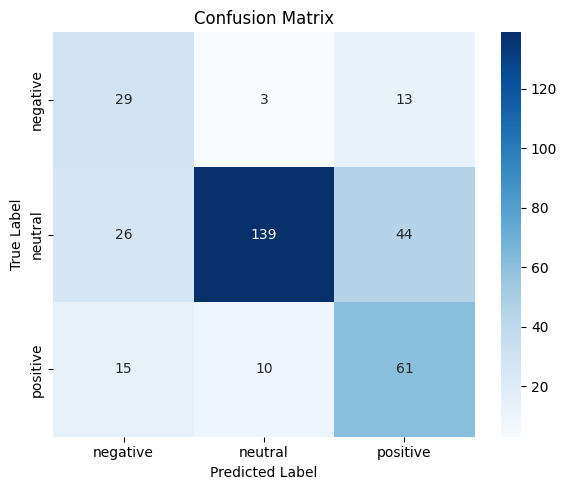

In [841]:

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


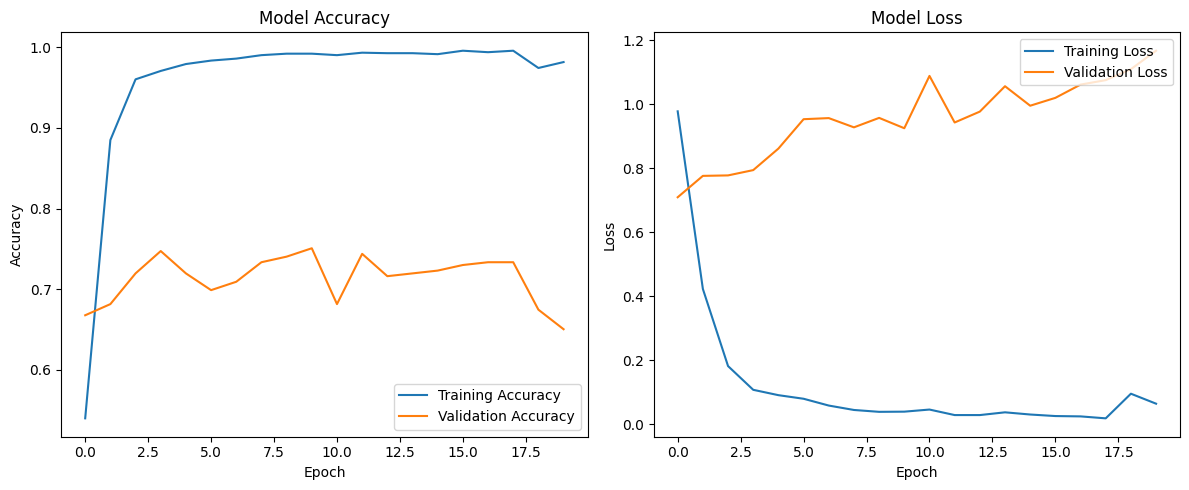

In [842]:
import matplotlib.pyplot as plt

# Get training and validation accuracy and loss
training_accuracy = history_rnn.history['accuracy']
validation_accuracy = history_rnn.history['val_accuracy']
training_loss = history_rnn.history['loss']
validation_loss = history_rnn.history['val_loss']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
ax1.plot(training_accuracy, label='Training Accuracy')
ax1.plot(validation_accuracy, label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

# Plot loss
ax2.plot(training_loss, label='Training Loss')
ax2.plot(validation_loss, label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

# Display the plots
plt.tight_layout()
plt.show()

### LSTM with a Trainable Embedding layer

In [843]:
# Callbacks
early_stop_lstm = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_lstm = ModelCheckpoint('best_lstm_model.h5', monitor='val_accuracy', save_best_only=True)


In [844]:
# Train the model
history_lstm = model_lstm.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_val_pad, y_val_cat),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop_lstm, checkpoint_lstm],
    class_weight=class_weight_dict
)

Epoch 1/20
52/52 [==============================] - 10s 64ms/step - loss: 1.0842 - accuracy: 0.3847 - val_loss: 0.7432 - val_accuracy: 0.6505
Epoch 2/20
 2/52 [>.............................] - ETA: 2s - loss: 0.6698 - accuracy: 0.8281

C:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - 3s 52ms/step - loss: 0.7374 - accuracy: 0.7168 - val_loss: 0.6617 - val_accuracy: 0.6782
Epoch 3/20
52/52 [==============================] - 3s 51ms/step - loss: 0.5836 - accuracy: 0.7792 - val_loss: 0.6494 - val_accuracy: 0.6817
Epoch 4/20
52/52 [==============================] - 3s 53ms/step - loss: 0.5305 - accuracy: 0.7657 - val_loss: 0.7566 - val_accuracy: 0.6401
Epoch 5/20
52/52 [==============================] - 3s 60ms/step - loss: 0.4901 - accuracy: 0.8067 - val_loss: 0.7230 - val_accuracy: 0.6886
Epoch 6/20
52/52 [==============================] - 3s 63ms/step - loss: 0.4513 - accuracy: 0.8526 - val_loss: 0.6633 - val_accuracy: 0.7266
Epoch 7/20
52/52 [==============================] - 3s 56ms/step - loss: 0.3732 - accuracy: 0.8936 - val_loss: 0.8074 - val_accuracy: 0.7232
Epoch 8/20
52/52 [==============================] - 3s 54ms/step - loss: 0.2538 - accuracy: 0.9352 - val_loss: 0.7511 - val_accuracy: 0.7682


In [845]:
# Evaluate test accuracy
loss, accuracy = model_lstm.evaluate(X_test_pad, y_test_cat, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

11/11 [==============================] - 0s 10ms/step - loss: 0.5863 - accuracy: 0.7029
Test Loss: 0.5863
Test Accuracy: 0.7029


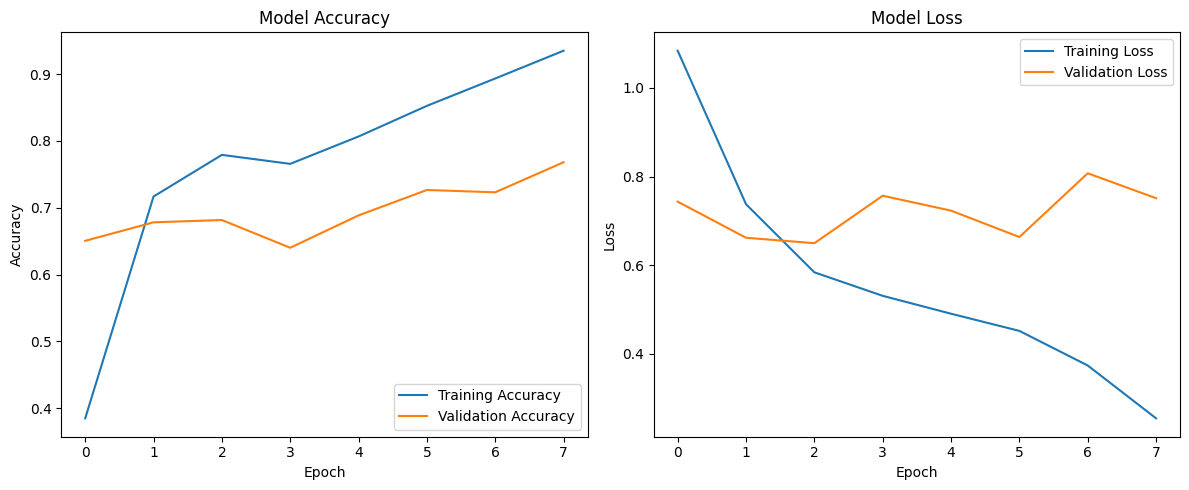

In [846]:
import matplotlib.pyplot as plt

# Get training and validation accuracy and loss
training_accuracy = history_lstm.history['accuracy']
validation_accuracy = history_lstm.history['val_accuracy']
training_loss = history_lstm.history['loss']
validation_loss = history_lstm.history['val_loss']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
ax1.plot(training_accuracy, label='Training Accuracy')
ax1.plot(validation_accuracy, label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

# Plot loss
ax2.plot(training_loss, label='Training Loss')
ax2.plot(validation_loss, label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

# Display the plots
plt.tight_layout()
plt.show()

In [847]:
# Predict class probabilities using the LSTM model
y_pred_lstm = model_lstm.predict(X_test_pad)

# Convert to predicted class labels (index of max prob)
y_pred = np.argmax(y_pred_lstm, axis=1)

# Convert one-hot test labels back to class indices
y_true = np.argmax(y_test_cat, axis=1)

# Classification report with zero_division parameter
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, zero_division=0))


11/11 [==============================] - 1s 9ms/step
Classification Report:
              precision    recall  f1-score   support

    negative       0.36      0.98      0.53        45
     neutral       0.90      0.90      0.90       209
    positive       0.60      0.07      0.12        86

    accuracy                           0.70       340
   macro avg       0.62      0.65      0.52       340
weighted avg       0.76      0.70      0.66       340



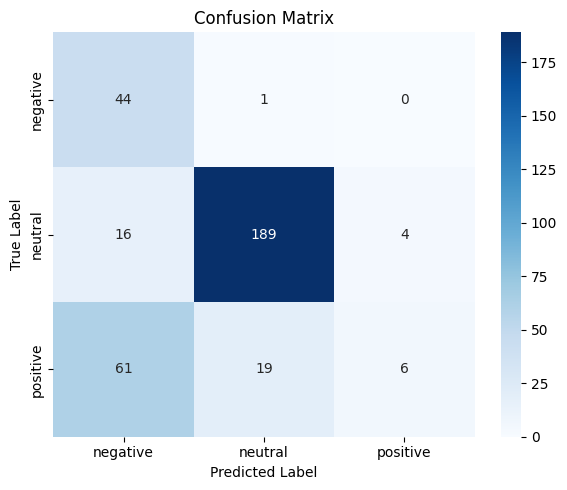

In [848]:

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


###  LSTM with Pretrained Word2Vec Embeddings

In [849]:
# Callbacks
early_stop_w2v = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_w2v = ModelCheckpoint('best_lstm_w2v_Try_model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model
history_w2v_Try = model.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_val_pad, y_val_cat),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop_w2v, checkpoint_w2v],
    class_weight=class_weight_dict
)

Epoch 1/20
52/52 [==============================] - 6s 50ms/step - loss: 0.9186 - accuracy: 0.5737 - val_loss: 0.7164 - val_accuracy: 0.6886
Epoch 2/20
 5/52 [=>............................] - ETA: 1s - loss: 0.7115 - accuracy: 0.7875

C:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - 2s 32ms/step - loss: 0.7542 - accuracy: 0.6893 - val_loss: 0.7383 - val_accuracy: 0.6678
Epoch 3/20
52/52 [==============================] - 2s 32ms/step - loss: 0.7150 - accuracy: 0.7095 - val_loss: 0.6148 - val_accuracy: 0.7093
Epoch 4/20
52/52 [==============================] - 2s 31ms/step - loss: 0.6916 - accuracy: 0.7089 - val_loss: 0.7676 - val_accuracy: 0.6332
Epoch 5/20
52/52 [==============================] - 2s 32ms/step - loss: 0.6644 - accuracy: 0.7125 - val_loss: 0.8435 - val_accuracy: 0.5848
Epoch 6/20
52/52 [==============================] - 2s 31ms/step - loss: 0.6224 - accuracy: 0.7401 - val_loss: 0.6557 - val_accuracy: 0.6713
Epoch 7/20
52/52 [==============================] - 2s 32ms/step - loss: 0.5836 - accuracy: 0.7694 - val_loss: 0.6215 - val_accuracy: 0.7266
Epoch 8/20
52/52 [==============================] - 2s 32ms/step - loss: 0.5606 - accuracy: 0.7902 - val_loss: 0.6237 - val_accuracy: 0.7439


In [850]:
# Evaluate test accuracy
loss, accuracy = model.evaluate(X_test_pad, y_test_cat, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

11/11 [==============================] - 0s 14ms/step - loss: 0.5642 - accuracy: 0.7441
Test Loss: 0.5642
Test Accuracy: 0.7441


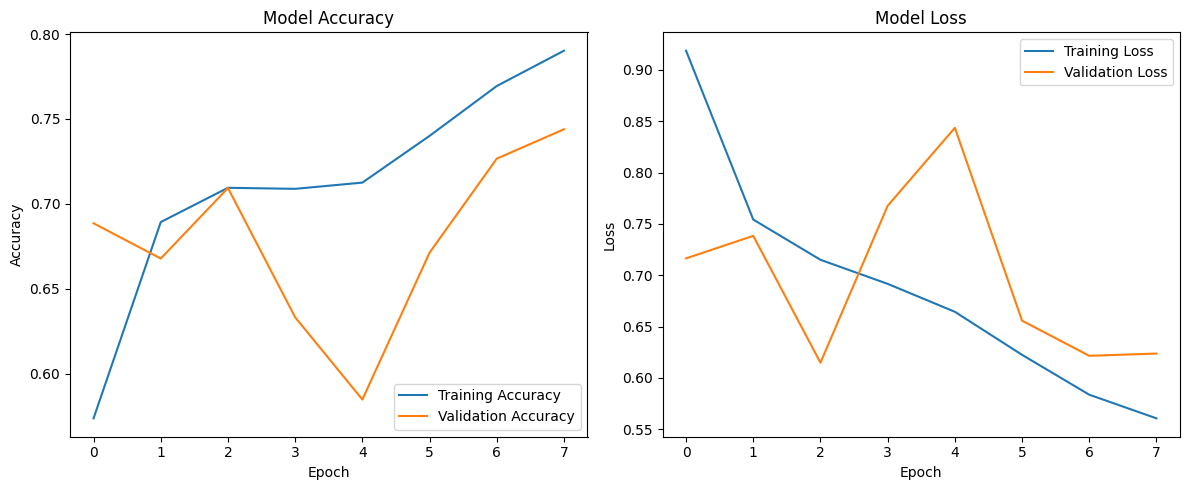

In [851]:
training_accuracy = history_w2v_Try.history['accuracy']
validation_accuracy = history_w2v_Try.history['val_accuracy']
training_loss = history_w2v_Try.history['loss']
validation_loss = history_w2v_Try.history['val_loss']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
ax1.plot(training_accuracy, label='Training Accuracy')
ax1.plot(validation_accuracy, label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

# Plot loss
ax2.plot(training_loss, label='Training Loss')
ax2.plot(validation_loss, label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

# Display the plots
plt.tight_layout()
plt.show()

In [852]:
# Predict class probabilities using the LSTM model
y_pred_probs = model.predict(X_test_pad)

# Convert to predicted class labels (index of max prob)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert one-hot test labels back to class indices
y_true = np.argmax(y_test_cat, axis=1)

# Classification report with zero_division parameter
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, zero_division=0))



11/11 [==============================] - 1s 14ms/step
Classification Report:
              precision    recall  f1-score   support

    negative       0.46      0.58      0.51        45
     neutral       0.88      0.91      0.89       209
    positive       0.55      0.42      0.47        86

    accuracy                           0.74       340
   macro avg       0.63      0.64      0.63       340
weighted avg       0.74      0.74      0.74       340



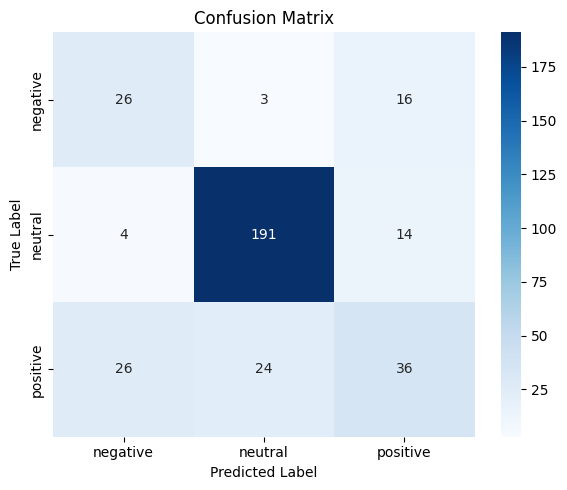

In [853]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


## Comparison of All Models

In [854]:
# Evaluate the models on test data (for example)
rnn_eval = model_rnn.evaluate(X_test_pad, y_test_cat, verbose=0)
lstm_eval = model_lstm.evaluate(X_test_pad, y_test_cat, verbose=0)
word2vec_eval = model.evaluate(X_test_pad, y_test_cat, verbose=0)

print(f"RNN Test Accuracy: {rnn_eval[1]}")
print(f"LSTM Test Accuracy: {lstm_eval[1]}")
print(f"Word2Vec LSTM Test Accuracy: {word2vec_eval[1]}")


RNN Test Accuracy: 0.6735293865203857
LSTM Test Accuracy: 0.7029411792755127
Word2Vec LSTM Test Accuracy: 0.7441176176071167


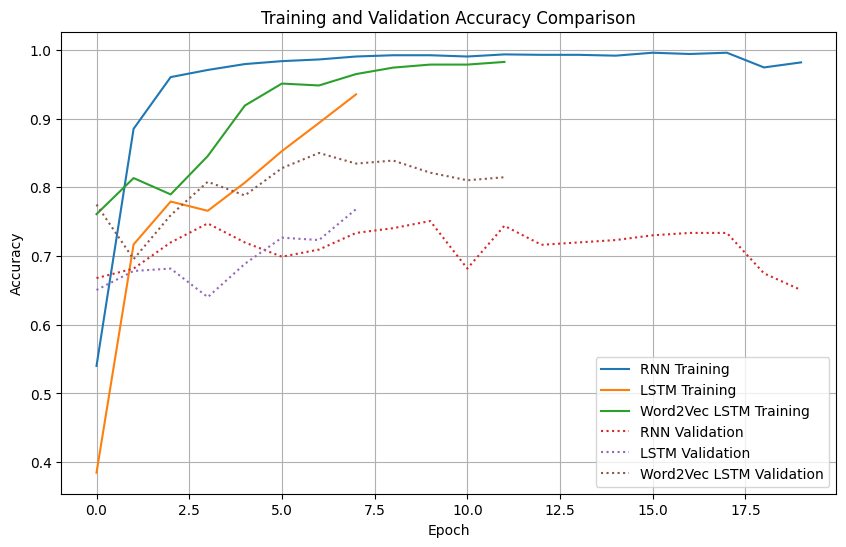

In [855]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Training Accuracy (normal lines)
plt.plot(history_rnn.history['accuracy'], label='RNN Training')
plt.plot(history_lstm.history['accuracy'], label='LSTM Training')
plt.plot(history_w2v.history['accuracy'], label='Word2Vec LSTM Training')

# Validation Accuracy (dotted lines)
plt.plot(history_rnn.history['val_accuracy'], label='RNN Validation', linestyle='dotted')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Validation', linestyle='dotted')
plt.plot(history_w2v.history['val_accuracy'], label='Word2Vec LSTM Validation', linestyle='dotted')

plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

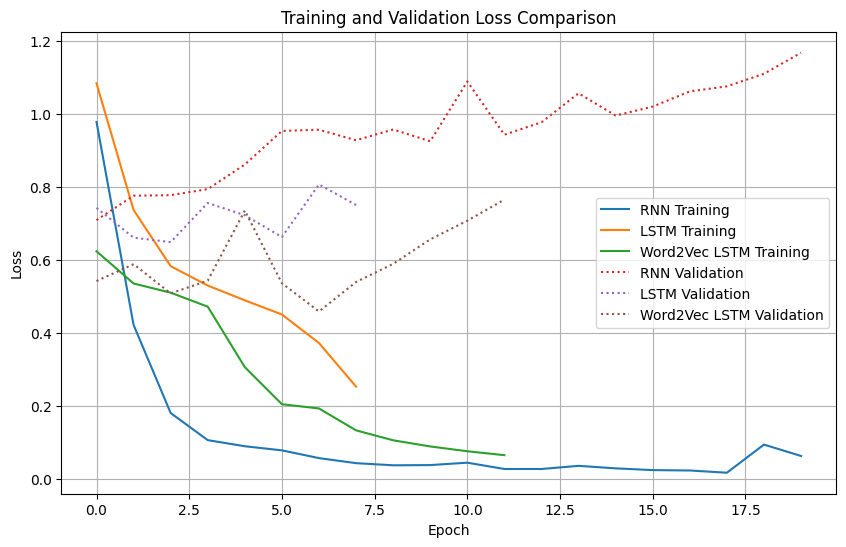

In [856]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Training Loss (normal lines)
plt.plot(history_rnn.history['loss'], label='RNN Training')
plt.plot(history_lstm.history['loss'], label='LSTM Training')
plt.plot(history_w2v.history['loss'], label='Word2Vec LSTM Training')

# Validation Loss (dotted lines)
plt.plot(history_rnn.history['val_loss'], label='RNN Validation', linestyle='dotted')
plt.plot(history_lstm.history['val_loss'], label='LSTM Validation', linestyle='dotted')
plt.plot(history_w2v.history['val_loss'], label='Word2Vec LSTM Validation', linestyle='dotted')

plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

# GUI

In [857]:
import threading
import tkinter as tk
from tkinter import scrolledtext
from keras.models import load_model

In [858]:

# Load models
rnn_model = load_model('best_rnn_model.h5')
lstm_model = load_model('best_lstm_model.h5')
word2vec_lstm_model = load_model('best_lstm_w2v_Try_model.h5')

In [859]:
def predict_sentiment(text):
    cleaned = preprocess_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    
    rnn_pred = rnn_model.predict(padded, verbose=0)
    lstm_pred = lstm_model.predict(padded, verbose=0)
    word2vec_pred = word2vec_lstm_model.predict(padded, verbose=0)

    print("RNN Raw Output:", rnn_pred)
    print("LSTM Raw Output:", lstm_pred)
    print("Word2Vec LSTM Raw Output:", word2vec_pred)

    # Convert to labels
    rnn_label = label_encoder.inverse_transform([np.argmax(rnn_pred)])[0]
    lstm_label = label_encoder.inverse_transform([np.argmax(lstm_pred)])[0]
    word2vec_label = label_encoder.inverse_transform([np.argmax(word2vec_pred)])[0]
    
    return rnn_label, lstm_label, word2vec_label


In [860]:
# Launch GUI
def launch_gui():
    root = tk.Tk()
    root.title("Financial Sentiment Analysis")
    root.geometry("600x500")

    # Title
    heading = tk.Label(root, text="Financial Sentiment Analysis", font=("Arial", 16, "bold"))
    heading.pack(pady=10)

    # Input label and text box
    input_label = tk.Label(root, text="Enter your text:")
    input_label.pack()
    input_text = scrolledtext.ScrolledText(root, height=5, width=70)
    input_text.pack(pady=5)

    # Analyse function
    def on_analyse():
        user_input = input_text.get("1.0", tk.END).strip()
        if user_input:
            rnn_result, lstm_result, word2vec_result = predict_sentiment(user_input)
            rnn_output.config(text=f"RNN: {rnn_result}")
            lstm_output.config(text=f"LSTM: {lstm_result}")
            word2vec_output.config(text=f"Word2vec LSTM: {word2vec_result}")

    # Analyse button
    analyse_button = tk.Button(root, text="Analyse", command=on_analyse)
    analyse_button.pack(pady=10)

    # Output labels
    output_label = tk.Label(root, text="Analyse output by Models:", font=("Arial", 12, "bold"))
    output_label.pack(pady=10)

    rnn_output = tk.Label(root, text="RNN:")
    rnn_output.pack()

    lstm_output = tk.Label(root, text="LSTM:")
    lstm_output.pack()

    word2vec_output = tk.Label(root, text="Word2vec LSTM:")
    word2vec_output.pack()

    root.mainloop()

# Start GUI in new thread so Jupyter doesn't freeze
threading.Thread(target=launch_gui).start()

In [861]:
launch_gui()